In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pulp
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [2]:
# Load the breast cancer dataset
#data = load_breast_cancer()
data = pd.read_csv("data_reduced.csv")
X = data.drop('target', axis=1)
y = data['target']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [20]:

# Number of clusters (assuming 2 for breast cancer classification: benign and malignant)
k = 2

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [21]:

# Define the MIP model
model = pulp.LpProblem("Breast_Cancer_Classification", pulp.LpMinimize)

# Number of data points and features
m, n = X_scaled.shape

# Variables
alpha = pulp.LpVariable.dicts("alpha", range(m), lowBound=0)
y_il = pulp.LpVariable.dicts("y_il", [(i, l) for i in range(m) for l in range(k)], cat='Binary')
z_il = pulp.LpVariable.dicts("z_il", [(i, l, j) for i in range(m) for l in range(k) for j in range(n)], lowBound=0)

# Objective function
model += pulp.lpSum(alpha[i] for i in range(m))

# Constraints
M = 1e6  # Large number for the big-M method

for i in range(m):
    for l in range(k):
        model += alpha[i] >= pulp.lpSum(z_il[(i, l, j)] for j in range(n))
        model += alpha[i] <= pulp.lpSum(z_il[(i, l, j)] for j in range(n)) + M * (1 - y_il[(i, l)])
        for j in range(n):
            model += z_il[(i, l, j)] >= X_scaled[i, j] - cluster_centers[l, j]
            model += z_il[(i, l, j)] >= -(X_scaled[i, j] - cluster_centers[l, j])

for i in range(m):
    model += pulp.lpSum(y_il[(i, l)] for l in range(k)) == 1

# Solve the MIP model
model.solve()

# Extract classification results
classification_results = [pulp.value(y_il[(i, l)]) for i in range(m) for l in range(k)]
classification = np.array(classification_results).reshape(m, k).argmax(axis=1)



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/q9/clg4hjcx3wgcds_vy_cwqc0m0000gn/T/4baf156907054bf798d2fca98ebaf5af-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/q9/clg4hjcx3wgcds_vy_cwqc0m0000gn/T/4baf156907054bf798d2fca98ebaf5af-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 48370 COLUMNS
At line 146808 RHS
At line 195174 BOUNDS
At line 196313 ENDATA
Problem MODEL has 48365 rows, 24467 columns and 95592 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 13512.4 - 0.36 seconds
Cgl0004I processed model has 2276 rows, 23898 columns (569 integer (569 of which binary)) and 48934 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 13512.4
Cbc0038I Relaxing continuous gives 13512.4
Cbc0038I

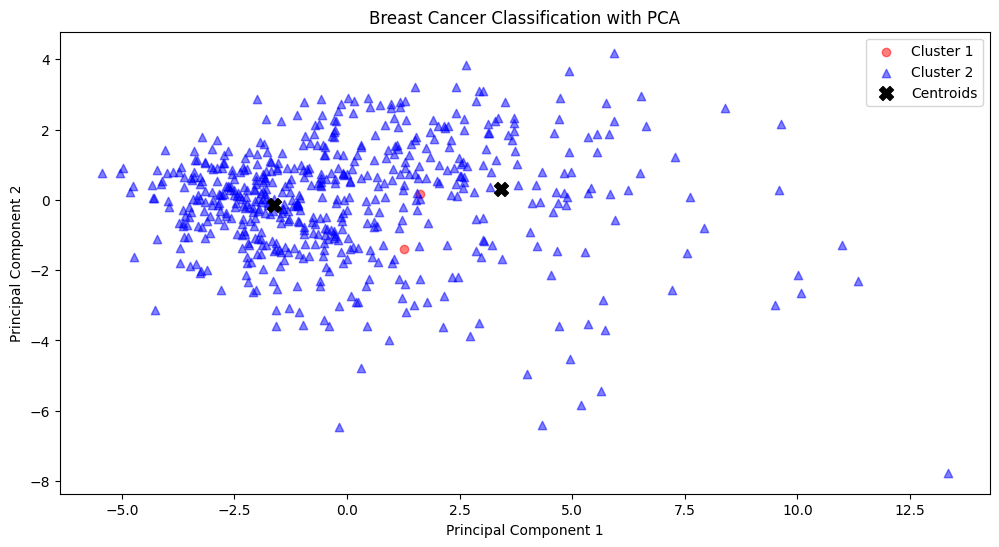

In [6]:
# Plot the PCA results
plt.figure(figsize=(12, 6))

# Scatter plot of the first two principal components
for i, color, marker in zip(range(k), ['red', 'blue'], ['o', '^']):
    plt.scatter(X_pca[classification == i, 0], X_pca[classification == i, 1], 
                color=color, marker=marker, label=f'Cluster {i + 1}', alpha=0.5)

# Plot the cluster centers
centers_pca = pca.transform(cluster_centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], color='black', marker='X', s=100, label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Breast Cancer Classification with PCA')
plt.legend()
plt.show()

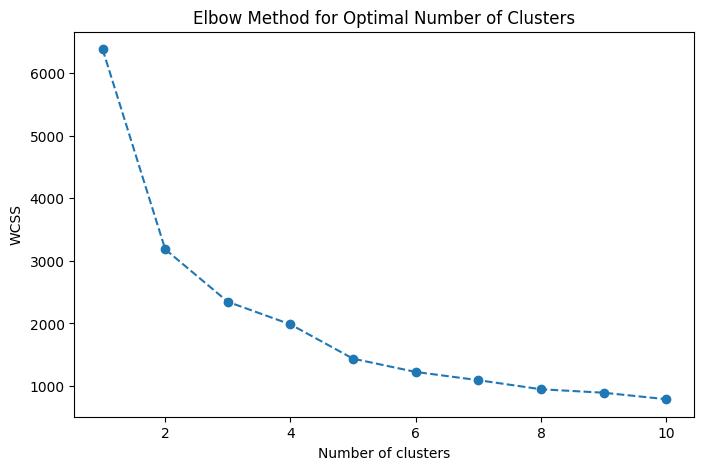

In [7]:
# Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to find the elbow point
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11, 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

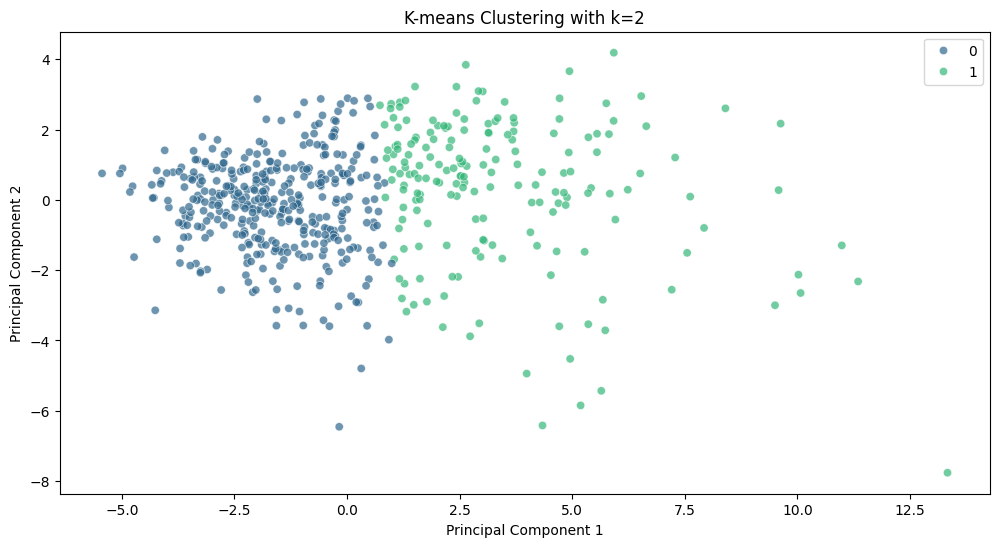

Silhouette Score for k=2: 0.30768888069707595


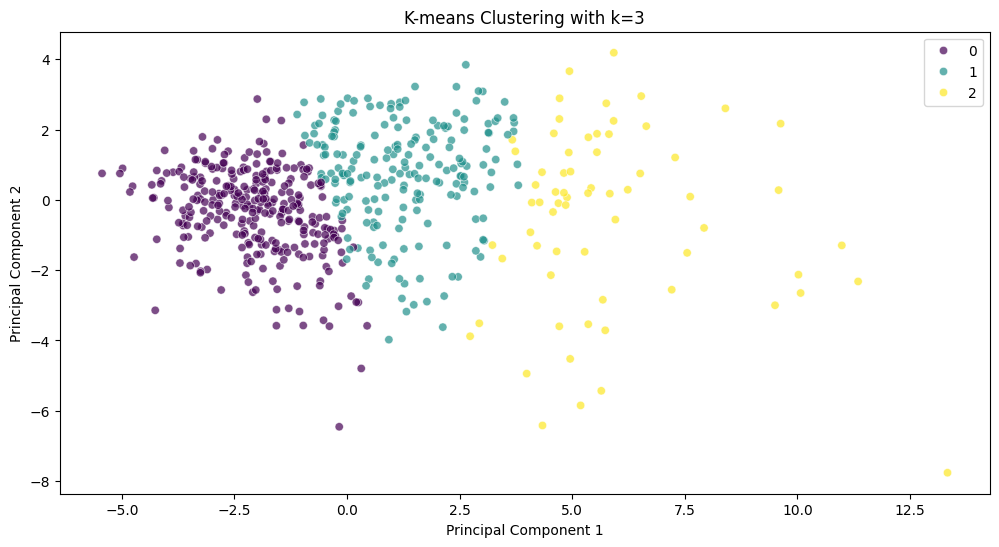

Silhouette Score for k=3: 0.1983330811955262


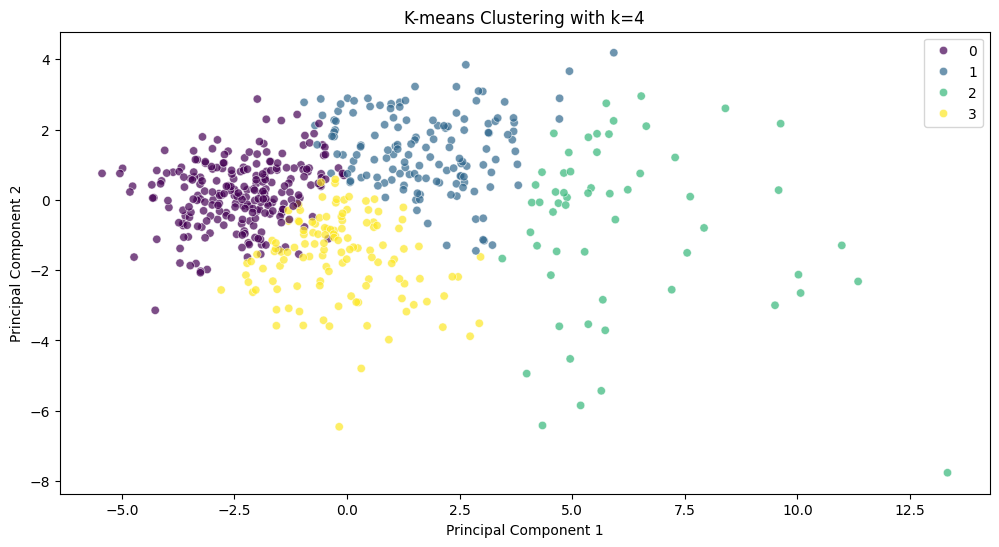

Silhouette Score for k=4: 0.1691007877142046


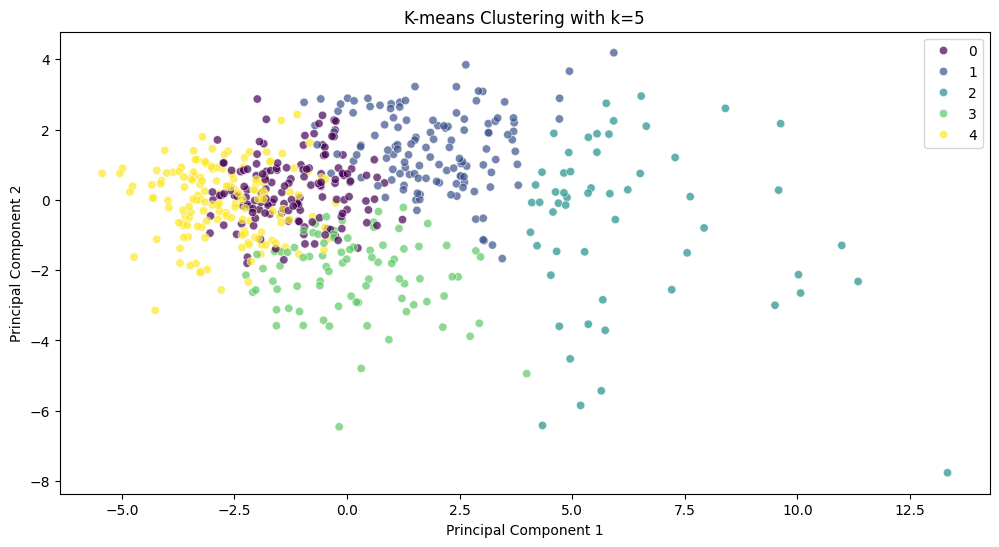

Silhouette Score for k=5: 0.11003107864649826


In [27]:
# Apply K-means clustering with different values of k and evaluate
best_k = 2
best_score = -1

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels_kmeans = kmeans.fit_predict(X_scaled)
    plot_clusters(X_pca, labels_kmeans, f'K-means Clustering with k={k}')
    silhouette_avg = silhouette_score(X_scaled, labels_kmeans)
    print(f'Silhouette Score for k={k}: {silhouette_avg}')
    if silhouette_avg > best_score:
        best_k = k
        best_score = silhouette_avg

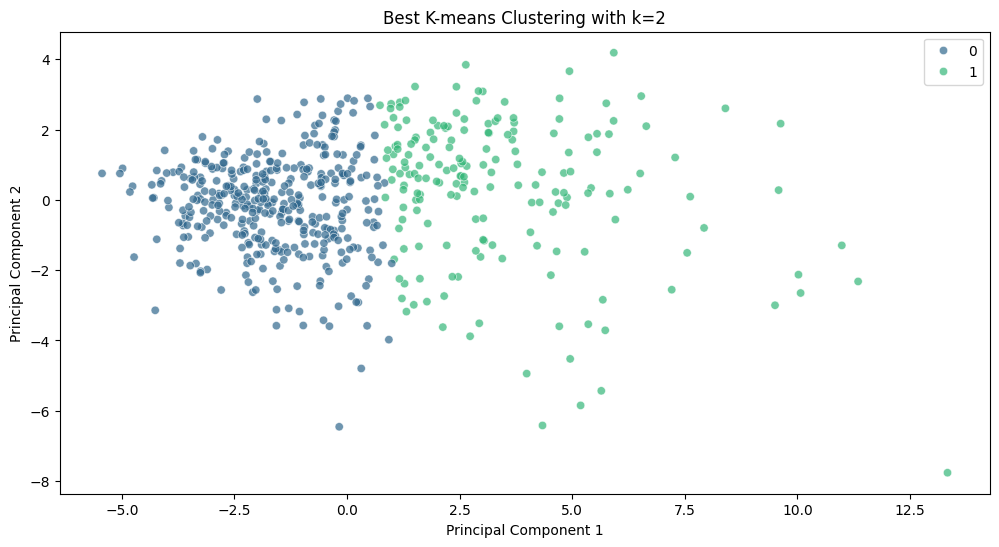

In [28]:
# Apply K-means clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)
plot_clusters(X_pca, labels_kmeans, f'Best K-means Clustering with k={best_k}')


In [30]:
# Evaluation metrics
ari = adjusted_rand_score(y, labels_kmeans)
nmi = normalized_mutual_info_score(y, labels_kmeans)

print(f'Best k: {best_k}')
print(f'Silhouette Score: {best_score}')
print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information Score: {nmi}')

Best k: 2
Silhouette Score: 0.30768888069707595
Adjusted Rand Index: 0.3878084738774274
Normalized Mutual Information Score: 0.2799657330160484


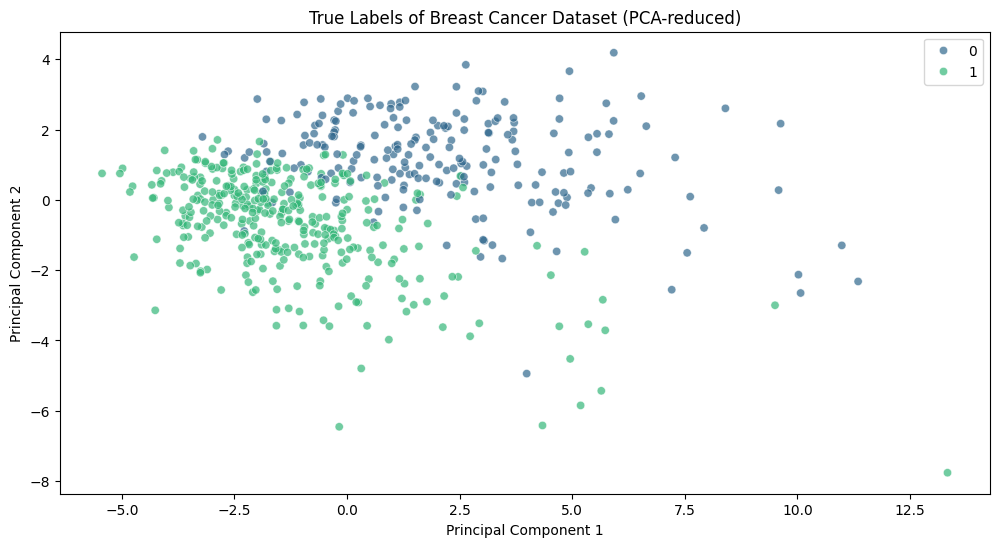

In [31]:
# Plot the true labels for comparison
plot_clusters(X_pca, y, 'True Labels of Breast Cancer Dataset (PCA-reduced)')